# The Enron Corpus
## Exploratory Data Analysis
##### Tania Lincoln 
##### January 15, 2018

<br>
### Background
Enron was one of the largest corporations in the United States.  By December 2002, it was bankrupt due to widespread corporate fraud and misleading accouting practices.  A Federal investigation resulted where many leaders were found guilty.

The Enron dataset contains approximately 600,000 emails generated by 158 employees of the Enron Corporation.  It was obtained by the Federal Energy Regulatory Commission during Enron's collapse.  At the conclusion of the investigation, the emails and information collected were deemed to be public domain to be used for research or academic purposes.

The corpus is unique in that its one of the only public mass collections of real emails available for study.

<br>
### Summary
In this project, we will study the corpus to build a person of interest identifier using emails and financial data.  A person of interest is someone who was indicted for fraud, settled, or testified in exchange for immunity.

This document will step through the EDA techniques to understand and clean the data; and explain machine learning algorithms applied to identify a person of interest.  Machine learning uses pattern recognition and statistics in a programatically to predict outcomes.  Because we are trying to identify a person of interest (boolean value), we will use supervised learning regression and classification alorithms.

Supervised learning because the algorithm learns from a training dataset, thought of as a teacher supervising the learning process.  The algorithm makes predictions on the training data.  Supervised learning can be further grouped into regression and classification.

<br>

### Import Libraries

In [1]:
#import basic libraries
import sys
import pickle
import numpy as np
import pandas as pd
import csv
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pprint

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

# add this path statement in order to add custom libraries
sys.path.append("../../ud120-projects-master/tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

sys.path.append("../utilities/")
from tool import scatter_plot

%matplotlib inline
pd.set_option('display.max_columns', None)

C:\Users\lincolnt\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Display Current Environment Info

In [2]:
# Always good practice to note the version info
print("python " + sys.version)
print("")
print("pandas " + str(pd.__version__))
print("numpy " + np.__version__)
print("matplotlib " + mpl.__version__)
print("seaborn " + sns.__version__)
print("stats " + statsmodels.__version__)

python 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 19 2016, 13:29:36) [MSC v.1500 64 bit (AMD64)]

pandas 0.19.2
numpy 1.13.1
matplotlib 2.0.0
seaborn 0.7.1
stats 0.6.1


### Load Data

In [3]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
### Put Data in Pandas DataFrame for easy exploration
df = pd.DataFrame.from_dict(data_dict, orient='index')

> ### List of Possible Features
> These features have been predefined in the project.  

>financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

>email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

>POI label: [‘poi’] (boolean, represented as integer)

### Initial Learnings

#### View Sample

In [5]:
### Sample a few rows
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,13868,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,56301,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,11200,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,129142,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


#### Basic Stats

In [6]:
### get basic stats
df.describe(include='all')

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
count,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146
unique,95,87,40,126,102,42,98,84,19,125,95,5,65,93,42,2,18,45,53,112,58
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
freq,51,60,107,21,44,64,36,60,128,20,51,142,60,53,60,128,129,97,80,35,60


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
exercised_stock_options      146 non-null object
bonus                        146 non-null object
restricted_stock             146 non-null object
shared_receipt_with_poi      146 non-null object
restricted_stock_deferred    146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
loan_advances                146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
director_fees                146 non-null object
deferred_income              146 non-null object


### Null Investigation

#### Modify NaN to real Nulls

In [8]:
### fill NaN with Nulls
df.replace(to_replace = 'NaN', value = np.NaN, inplace = True)

#### How many columns have nulls

In [9]:
# Count the Nulls
print df.isnull().sum()

salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
exercised_stock_options       44
bonus                         64
restricted_stock              36
shared_receipt_with_poi       60
restricted_stock_deferred    128
total_stock_value             20
expenses                      51
loan_advances                142
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
director_fees                129
deferred_income               97
long_term_incentive           80
email_address                 35
from_poi_to_this_person       60
dtype: int64


With only 146 rows, we may drop deferral_payments, restricted_stock_defferred, loan_advances, director_fees.

#### How many nulls are in each row

In [10]:
df.isnull().sum(axis=1).sort_values(ascending=False).head(20)

LOCKHART EUGENE E                20
GRAMM WENDY L                    18
WROBEL BRUCE                     18
WHALEY DAVID A                   18
THE TRAVEL AGENCY IN THE PARK    18
WAKEHAM JOHN                     17
WODRASKA JOHN                    17
CLINE KENNETH W                  17
GILLIS JOHN                      17
SCRIMSHAW MATTHEW                17
SAVAGE FRANK                     17
MENDELSOHN JOHN                  16
YEAP SOON                        16
CHRISTODOULOU DIOMEDES           16
PEREIRA PAULO V. FERRAZ          16
BLAKE JR. NORMAN P               16
LOWRY CHARLES P                  16
CHAN RONNIE                      16
MEYER JEROME J                   16
GATHMANN WILLIAM D               16
dtype: int64

Alot of the rows have nulls, we may remove several of these too.

### Basic Questions

#### How many people are in the dataset?

In [11]:
### How many people are in the dataset
print "There are", len(df.index), \
    "executives within the Enron corpus."

There are 146 executives within the Enron corpus.


#### Who is in the dataset?

In [12]:
### Look at the keys
print "These are the keys in the dataset \n"
print(df.index)

These are the keys in the dataset 

Index([u'ALLEN PHILLIP K', u'BADUM JAMES P', u'BANNANTINE JAMES M',
       u'BAXTER JOHN C', u'BAY FRANKLIN R', u'BAZELIDES PHILIP J',
       u'BECK SALLY W', u'BELDEN TIMOTHY N', u'BELFER ROBERT',
       u'BERBERIAN DAVID',
       ...
       u'WASAFF GEORGE', u'WESTFAHL RICHARD K', u'WHALEY DAVID A',
       u'WHALLEY LAWRENCE G', u'WHITE JR THOMAS E', u'WINOKUR JR. HERBERT S',
       u'WODRASKA JOHN', u'WROBEL BRUCE', u'YEAGER F SCOTT', u'YEAP SOON'],
      dtype='object', length=146)


#### How many people are POIs?

In [13]:
### Find out how many POIs are in the dataset
print "There are", len(df[df['poi']==1]), "people of interests"
print "This represents", round((float(len(df[df['poi']==1]))/float(len(df)))*100,2), "% of the data."

There are 18 people of interests
This represents 12.33 % of the data.


#### How many features are assigned to each person?

In [14]:
### Find out how many features have been assigned to each person
print "There are", min(df.count(axis=1)), "-" , max(df.count(axis=1)), "features assigned to each person."

There are 1 - 19 features assigned to each person.


### Basic Data Integrity

#### Fill NaN with 0s for Math Checks

In [15]:
### fill NaN with 0
df_check = df.replace(to_replace = 'NaN', value = 0)

#### Check Total Payments

In [16]:
### create an array of columns to manually check total_payments
manual_total_payments = ['salary',
                       'bonus',
                       'long_term_incentive',
                       'deferred_income',
                       'deferral_payments',
                       'loan_advances',
                       'other',
                       'expenses',
                       'director_fees']

df_check[df_check[manual_total_payments].sum(axis='columns') != \
         df_check.total_payments]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BELFER ROBERT,0.0,0.0,-102500.0,102500.0,3285.0,0.0,0.0,0.0,44093.0,-44093.0,0.0,0.0,0.0,0.0,0.0,False,3285.0,0.0,0.0,NaN,0.0
BHATNAGAR SANJAY,0.0,523.0,0.0,15456290.0,2604490.0,0.0,-2604490.0,463.0,15456290.0,0.0,0.0,0.0,29.0,137864.0,1.0,False,137864.0,0.0,0.0,sanjay.bhatnagar@enron.com,0.0


We may remove or fix these rows.

#### Check Total Stock

In [17]:
### create an array of stock columns to check total_stock
manual_total_stock = ['exercised_stock_options',
                    'restricted_stock',
                    'restricted_stock_deferred']

df_check[df_check[manual_total_stock].sum(axis='columns') != \
         df_check.total_stock_value]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BELFER ROBERT,0.0,0.0,-102500.0,102500.0,3285.0,0.0,0.0,0.0,44093.0,-44093.0,0.0,0.0,0.0,0.0,0.0,False,3285.0,0.0,0.0,NaN,0.0
BHATNAGAR SANJAY,0.0,523.0,0.0,15456290.0,2604490.0,0.0,-2604490.0,463.0,15456290.0,0.0,0.0,0.0,29.0,137864.0,1.0,False,137864.0,0.0,0.0,sanjay.bhatnagar@enron.com,0.0


We may remove or fix these rows.

### Visualize data

#### What does total payments and total stock value look like?

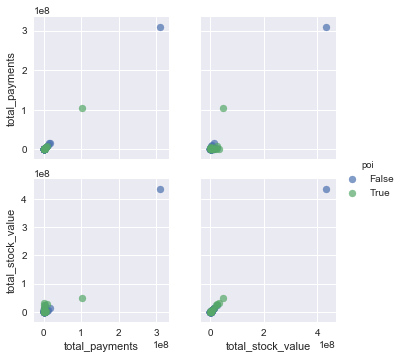

In [18]:
g = sns.PairGrid(df, hue='poi', vars=['total_payments', 'total_stock_value'])
g = g.map(plt.scatter, alpha=.7)
g = g.add_legend()

We see there is a plotted point with over \$300,000,000 of payments and \$100,000,000 of stock.  
This outlier is so far away from the majaority of the points.  We will need to investigate this more.

#### Outlier investigation

In [19]:
### There is a huge outlier, further investigate who it belongs to
print "The ID with the higest salary and bonus are:\n"
print(df['total_payments'].idxmax())
print(df['total_stock_value'].idxmax())


The ID with the higest salary and bonus are:

TOTAL
TOTAL


A total row is in the dataset.  This will be removed so we know we're working with a dataset of real people.

#### Check outliers in other features to see if there are other "people" to delete

In [20]:
### http://www.mathwords.com/o/outlier.htm
### https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.quantile.html
outliers = 1.5 * (df.quantile(.75)-df.quantile(.25))

In [21]:
### print the outlier values
outliers

salary                       1.504515e+05
to_messages                  3.140250e+03
deferral_payments            1.381648e+06
total_payments               2.548182e+06
exercised_stock_options      3.029757e+06
bonus                        1.153125e+06
restricted_stock             1.122528e+06
shared_receipt_with_poi      2.457750e+03
restricted_stock_deferred    4.719180e+05
total_stock_value            3.683005e+06
expenses                     8.600775e+04
loan_advances                1.207875e+08
from_messages                1.841250e+02
other                        5.413215e+05
from_this_person_to_poi      3.562500e+01
poi                          0.000000e+00
director_fees                2.250000e+04
deferred_income              9.847740e+05
long_term_incentive          9.861330e+05
from_poi_to_this_person      9.337500e+01
dtype: float64

In [22]:
### show the number of times a person had an outlier value
### make sure they are real people.
(df > outliers).sum(axis=1).sort_values(ascending = False).head(25)

FREVERT MARK A         14
LAY KENNETH L          13
LAVORATO JOHN J        12
TOTAL                  11
BELDEN TIMOTHY N       11
WHALLEY LAWRENCE G     11
DELAINEY DAVID W       10
SKILLING JEFFREY K     10
SHANKMAN JEFFREY A      9
KITCHEN LOUISE          9
KEAN STEVEN J           9
HAEDICKE MARK E         8
RICE KENNETH D          8
BAXTER JOHN C           8
HORTON STANLEY C        7
ALLEN PHILLIP K         7
SHERRIFF JOHN R         7
PAI LOU L               7
SHAPIRO RICHARD S       7
HANNON KEVIN P          7
FALLON JAMES B          7
BECK SALLY W            7
FASTOW ANDREW S         6
YEAGER F SCOTT          6
MCCONNELL MICHAEL S     6
dtype: int64

With the exception of TOTAL, these are real people and can remain in the dataset.  Crazy that 3 people would surpass a summary row, probably has to do with negative values.

#### Check to see if there are other entries that are obviously not a person

In [23]:
### Most names appear to follow this format:
### last name, first name, middle intitial
### because we found a name of "TOTAL",
### let's see if there is anything else to remove.      
pprint.pprint(df.index[df.index.str.split().str.len() <= 1])


Index([u'TOTAL'], dtype='object')


There are no other rows with a single word name.

In [24]:
### Most names appear to follow this format:
### last name, first name, middle intitial
### because we found a name of "TOTAL",
### let's see if there is anything else to remove.      
pprint.pprint(df.index[df.index.str.split().str.len() > 3])


Index([u'BLAKE JR. NORMAN P', u'BOWEN JR RAYMOND M', u'DERRICK JR. JAMES V',
       u'DONAHUE JR JEFFREY M', u'GLISAN JR BEN F', u'OVERDYKE JR JERE C',
       u'PEREIRA PAULO V. FERRAZ', u'THE TRAVEL AGENCY IN THE PARK',
       u'WALLS JR ROBERT H', u'WHITE JR THOMAS E', u'WINOKUR JR. HERBERT S'],
      dtype='object')


The Travel Agency In The Park seems wrong.  Examine it.

#### Look at the Travel Agency Row

In [25]:
df.ix['THE TRAVEL AGENCY IN THE PARK']

salary                          NaN
to_messages                     NaN
deferral_payments               NaN
total_payments               362096
exercised_stock_options         NaN
bonus                           NaN
restricted_stock                NaN
shared_receipt_with_poi         NaN
restricted_stock_deferred       NaN
total_stock_value               NaN
expenses                        NaN
loan_advances                   NaN
from_messages                   NaN
other                        362096
from_this_person_to_poi         NaN
poi                           False
director_fees                   NaN
deferred_income                 NaN
long_term_incentive             NaN
email_address                   NaN
from_poi_to_this_person         NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

Because this is not a person of interest and most columns are null, we will remove this row as part of the data cleansing.

### Clean Data

#### Remove Total Row

In [26]:
### Remove outliers
df.drop('TOTAL', inplace = True)

#### Remove The Travel Agency in the Park Row

In [27]:
### Remove outliers
df.drop('THE TRAVEL AGENCY IN THE PARK', inplace = True)

#### Drop Rows or Rows Failing Internal Checks

In [28]:
### 20 columns were null
df.drop('LOCKHART EUGENE E', inplace = True)

### internal referencial integrity was missing 
df.drop('BELFER ROBERT', inplace = True)
df.drop('BHATNAGAR SANJAY', inplace = True)


#### Drop Columns

In [29]:
### Drop the email column
df.drop('email_address', axis=1, inplace=True)

### Post Clean-up Checks

#### Check Null Columns

In [30]:
### check results
print df.isnull().sum().sort_values(ascending=False).head()

loan_advances                138
director_fees                127
restricted_stock_deferred    126
deferral_payments            104
deferred_income               93
dtype: int64


#### Check Null Rows

In [31]:
df.isnull().sum(axis=1).sort_values(ascending=False).head()

GRAMM WENDY L        17
WROBEL BRUCE         17
WODRASKA JOHN        17
SCRIMSHAW MATTHEW    17
WHALEY DAVID A       17
dtype: int64

#### How many people are in the dataset now?

In [32]:
### How many people are in the dataset
print "There are", len(df.index), \
    "executives within the Enron corpus.  There used to be 146."

There are 141 executives within the Enron corpus.  There used to be 146.


#### Visualize Data

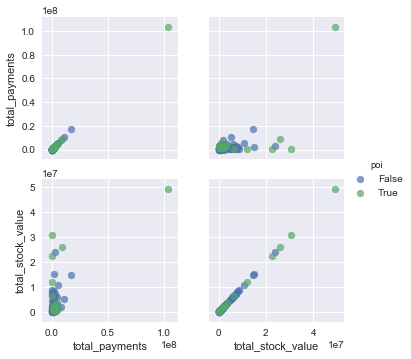

In [33]:
### re-plot payments and stock
g = sns.PairGrid(df, hue='poi', vars=['total_payments', 'total_stock_value'])
g = g.map(plt.scatter, alpha=.7)
g = g.add_legend()

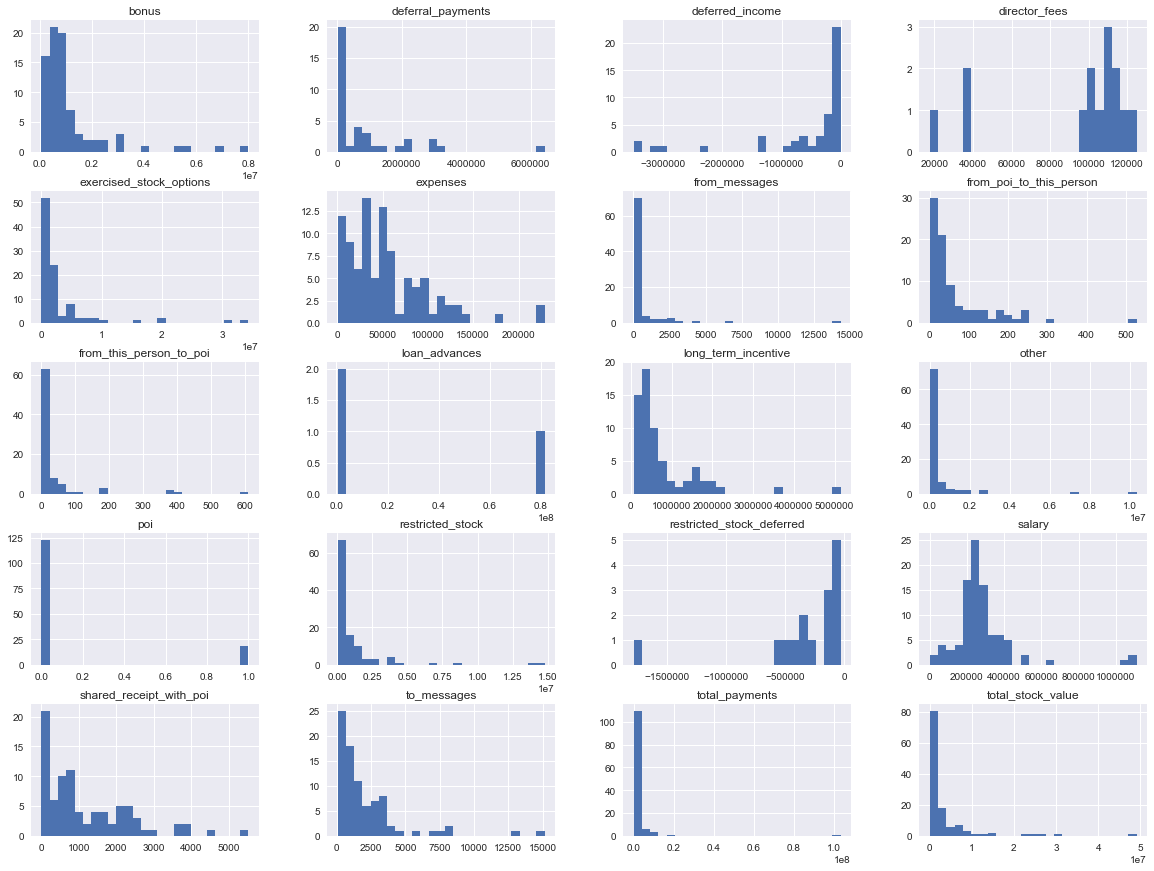

In [34]:
### let's vizualize everything in histograms
_ = df.hist(figsize=(20,15), bins=25)

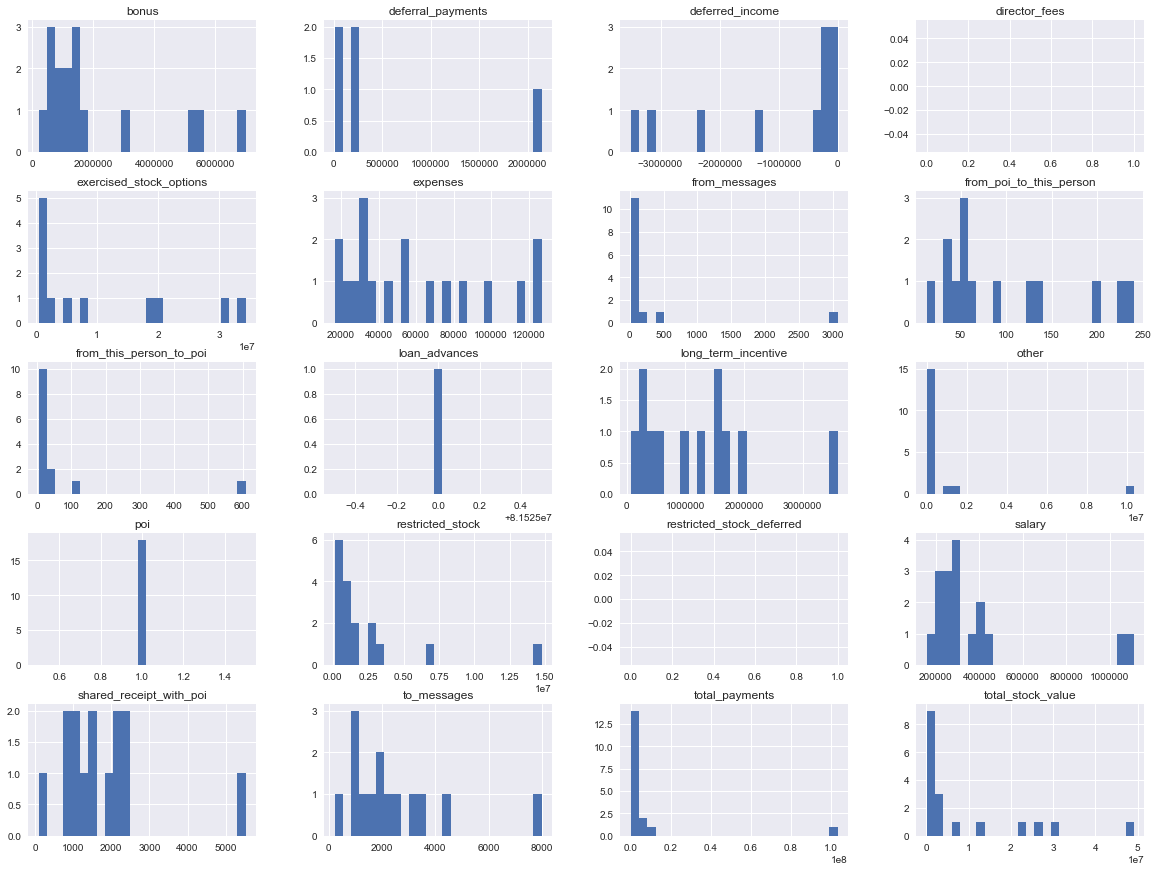

In [35]:
### let's vizualize everything in histograms
_ = df[df['poi']==True].hist(figsize=(20,15), bins=25)

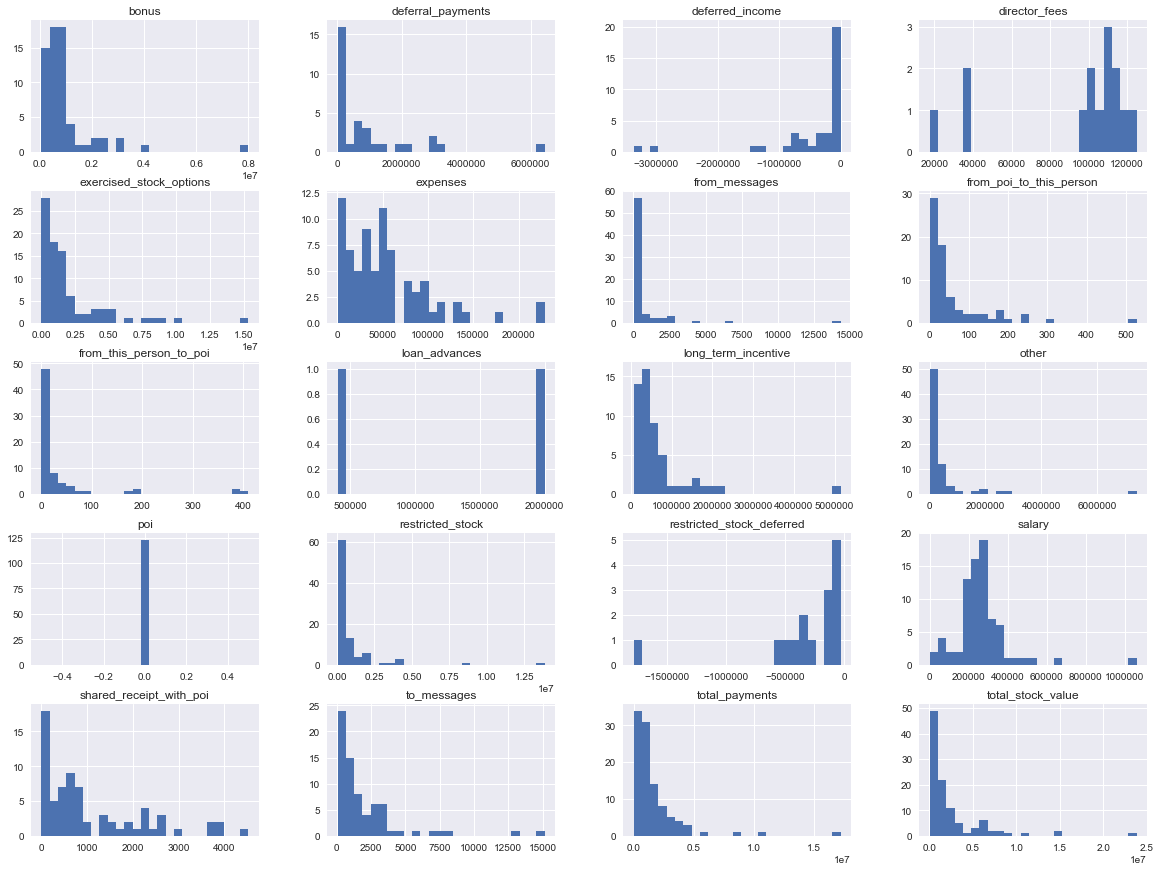

In [36]:
### let's vizualize everything in histograms
_ = df[df['poi']==False].hist(figsize=(20,15), bins=25)

### Put Dataframe in Dictionary for ML

#### Replace Nulls with 0s

In [37]:
### replace the NaNs with 0s.
### we are ready to put this back in a dictionary for ML
df_trial1 = df.replace(to_replace = 'NaN', value = 0)

In [38]:
### change the pandas dataframe to a dictionary
### https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_dict.html
my_dict1 = df_trial1.to_dict('index')

In [39]:
### print one  out to make sure it looks right
iterator = 0

for key in my_dict1:
    if iterator < 1:
        print key
        pprint.pprint(my_dict1[key])
        iterator += 1

METTS MARK
{'bonus': 600000.0,
 'deferral_payments': 0.0,
 'deferred_income': 0.0,
 'director_fees': 0.0,
 'exercised_stock_options': 0.0,
 'expenses': 94299.0,
 'from_messages': 29.0,
 'from_poi_to_this_person': 38.0,
 'from_this_person_to_poi': 1.0,
 'loan_advances': 0.0,
 'long_term_incentive': 0.0,
 'other': 1740.0,
 'poi': False,
 'restricted_stock': 585062.0,
 'restricted_stock_deferred': 0.0,
 'salary': 365788.0,
 'shared_receipt_with_poi': 702.0,
 'to_messages': 807.0,
 'total_payments': 1061827.0,
 'total_stock_value': 585062.0}


### Split Data into Train and Test Datasets

In [40]:
### use the df to create a feature list programaticaly
features_list1 = list(df)
features_list1.remove('poi')
features_list1.insert(0, 'poi')

In [41]:
### Extract features and labels from dataset for local testing
data1 = featureFormat(my_dict1, features_list1, sort_keys = True)
labels, features = targetFeatureSplit(data1)

In [42]:
### Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Try Models Before Feature Changes

In [43]:
### Try various models, these perform best with binary classification
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(features_train, labels_train)
    
    predictions = clf.predict(features_test)
    acc = metrics.accuracy_score(labels_test, predictions)
    
    predictions = clf.predict_proba(features_test)
    ll = metrics.log_loss(labels_test, predictions)
   
    name = clf.__class__.__name__
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)

In [44]:
log

,Classifier,Accuracy,Log Loss
0,LogisticRegression,88.372093,0.593894
0,KNeighborsClassifier,90.697674,1.004547
0,SVC,90.697674,0.314360
0,DecisionTreeClassifier,83.720930,5.622592
0,RandomForestClassifier,95.348837,0.253441
0,GaussianNB,76.744186,3.130051


### Add Features

#### Make New True/False Features

In [45]:
### create a dictionary of the top 6 null columns
my_null_list = df.isnull().sum().sort_values(ascending=False).head(6).to_dict()

### for every key in the dictionary, make a new true/false column in the dataframe
for key in my_null_list:
    df['has_' + key + '_bool'] = df[key].notnull()

In [46]:
### check a few
df[df['has_deferral_payments_bool']==True].head(2)

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,has_deferral_payments_bool,has_long_term_incentive_bool,has_restricted_stock_deferred_bool,has_loan_advances_bool,has_deferred_income_bool,has_director_fees_bool
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,NaN,2195.0,152.0,65.0,False,NaN,-3081055.0,304805.0,47.0,True,True,True,False,True,False
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,3486.0,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,True,False,False,False,False,False


In [47]:
### check a few
df[df['has_deferral_payments_bool']==False].head(2)

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,has_deferral_payments_bool,has_long_term_incentive_bool,has_restricted_stock_deferred_bool,has_loan_advances_bool,has_deferred_income_bool,has_director_fees_bool
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,56301.0,NaN,29.0,864523.0,0.0,False,NaN,-5104.0,NaN,39.0,False,False,True,False,True,False
BECK SALLY W,231330.0,7315.0,NaN,969068.0,NaN,700000.0,126027.0,2639.0,NaN,126027.0,37172.0,NaN,4343.0,566.0,386.0,False,NaN,NaN,NaN,144.0,False,False,False,False,False,False


#### Make New Ratio Feature

In [48]:
### createa a few ratios of emails compared to those from/to poi
df['ratio_of_to_messages_poi'] = \
    df['from_poi_to_this_person']/df['to_messages']
    
df['ratio_of_from_messages_poi'] = \
    df['from_this_person_to_poi']/df['from_messages']

In [49]:
### see a few of the rows
df[['ratio_of_to_messages_poi', 'ratio_of_from_messages_poi']].head()

,ratio_of_to_messages_poi,ratio_of_from_messages_poi
ALLEN PHILLIP K,0.016196,0.029613
BADUM JAMES P,NaN,NaN
BANNANTINE JAMES M,0.068905,0.000000
BAXTER JOHN C,NaN,NaN
BAY FRANKLIN R,NaN,NaN


#### Replace Nulls with 0s

In [50]:
### replace the NaNs with 0s.
### we are ready to put this back in a dictionary for ML
df_trial2 = df.replace(to_replace = 'NaN', value = 0)

### Put Dataframe in Dictionary for ML

In [51]:
### use the df to create a feature list programaticaly
features_list2 = list(df_trial2)
features_list2.remove('poi')
features_list2.insert(0, 'poi')
features_list2

['poi',
 'salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person',
 'has_deferral_payments_bool',
 'has_long_term_incentive_bool',
 'has_restricted_stock_deferred_bool',
 'has_loan_advances_bool',
 'has_deferred_income_bool',
 'has_director_fees_bool',
 'ratio_of_to_messages_poi',
 'ratio_of_from_messages_poi']

#### Remove features with Nulls

In [52]:
### Removed part of trial2 and again part of trial3
features_list2.remove('deferral_payments')
features_list2.remove('restricted_stock_deferred')
features_list2.remove('loan_advances')
features_list2.remove('director_fees')
features_list2.remove('deferred_income')
features_list2.remove('long_term_incentive')

### Removed part of trial3
features_list2.remove('has_deferral_payments_bool')
features_list2.remove('has_long_term_incentive_bool')
features_list2.remove('has_restricted_stock_deferred_bool')
features_list2.remove('has_loan_advances_bool')
features_list2.remove('has_deferred_income_bool')
features_list2.remove('has_director_fees_bool')


In [53]:
### change the pandas dataframe to a dictionary
### https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_dict.html
my_dict2 = df_trial2.to_dict('index')

In [54]:
### print one  out to make sure it looks right
iterator = 0

for key in my_dict2:
    if iterator < 1:
        print key
        pprint.pprint(my_dict2[key])
        iterator += 1

METTS MARK
{'bonus': 600000.0,
 'deferral_payments': 0.0,
 'deferred_income': 0.0,
 'director_fees': 0.0,
 'exercised_stock_options': 0.0,
 'expenses': 94299.0,
 'from_messages': 29.0,
 'from_poi_to_this_person': 38.0,
 'from_this_person_to_poi': 1.0,
 'has_deferral_payments_bool': False,
 'has_deferred_income_bool': False,
 'has_director_fees_bool': False,
 'has_loan_advances_bool': False,
 'has_long_term_incentive_bool': False,
 'has_restricted_stock_deferred_bool': False,
 'loan_advances': 0.0,
 'long_term_incentive': 0.0,
 'other': 1740.0,
 'poi': False,
 'ratio_of_from_messages_poi': 0.034482758620689655,
 'ratio_of_to_messages_poi': 0.04708798017348203,
 'restricted_stock': 585062.0,
 'restricted_stock_deferred': 0.0,
 'salary': 365788.0,
 'shared_receipt_with_poi': 702.0,
 'to_messages': 807.0,
 'total_payments': 1061827.0,
 'total_stock_value': 585062.0}


### Split Data into Train and Test Datasets

In [55]:
### Extract features and labels from dataset for local testing
data2 = featureFormat(my_dict2, features_list2, sort_keys = True)
labels, features = targetFeatureSplit(data2)

In [56]:
### Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Try Models Before Feature Changes

In [57]:
### Try various models, these best perform with binary classification
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(features_train, labels_train)
    
    predictions = clf.predict(features_test)
    acc = metrics.accuracy_score(labels_test, predictions)
    
    predictions = clf.predict_proba(features_test)
    ll = metrics.log_loss(labels_test, predictions)
   
    name = clf.__class__.__name__
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)

In [58]:
log

,Classifier,Accuracy,Log Loss
0,LogisticRegression,81.395349,0.673679
0,KNeighborsClassifier,90.697674,1.014926
0,SVC,90.697674,0.318700
0,DecisionTreeClassifier,79.069767,7.229046
0,RandomForestClassifier,88.372093,0.288795
0,GaussianNB,86.046512,1.704157


#### Compare the Results

Most of the classifier performance became worse after the features were developed.
<br>

|Classifier            |Trial 1|Trial 2|Trial 3|
|----------------------|-------|-------|-------|
|Logistic Regression   |  88.37|  76.74|  81.39|
|KNeighborsClassifier  |  90.69|  90.69|  90.69|
|SVC                   |  90.69|  90.69|  90.69|
|DecisionTreeClassifier|  83.72|  76.74|  79.06|
|RandomForestClassifier|  90.69|  86.04|  81.39|
|GaussianNB            |  76.74|  86.04|  86.04|

<br>

The new features ddi not improve the classifiers and will not be used.  

The best performing classifiers are KNeighborsClassifier, SVC, and RandomForestClassifier in Trial1.


### Overview of Best Methods and Models

#### Feature Selection Method

I did a before and after test with the known features and then with my custom features.  The custom features seems to diminish accuracy in most of the models except for GaussianNB.  I decided to use the initial set of features instead of the newly created ones.

|Classifier            |Trial 1|Trial 2|Trial 3|
|----------------------|-------|-------|-------|
|Logistic Regression   |  88.37|  76.74|  81.39|
|KNeighborsClassifier  |  90.69|  90.69|  90.69|
|SVC                   |  90.69|  90.69|  90.69|
|DecisionTreeClassifier|  83.72|  76.74|  79.06|
|RandomForestClassifier|  90.69|  86.04|  81.39|
|GaussianNB            |  76.74|  86.04|  86.04|

Interestingly, I could not get the models to show a recall or precision value of .3 or greater (a project requirement).  Later I learned that I had left many of the features with high null values in the list.  Once I removed these, everything improved.

With the iterations above, we decide on the following list of features.
['poi',
 'salary',
 'to_messages',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_stock_value',
 'expenses',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'from_poi_to_this_person']

We use Kbest as an example of univariate feature selection and PCA as another method of dimensionality reduction in the next pass of model selection and tuning.

Our GridSearchCV will tune our parameters and find the best number of dimensions.  It works by refitting an N and N-1 dimension space while maintaining the most variance.

SelectKbest works by scoring each feature for its predictive power than selecting the best performing number of them.

#### Classification Method

During the initial trials, using the default setting, we see that Logistic Regression, KNeighborsClassifier, SVC, and RandomForestClassifier had the highest accuracy, the top 4.  We decide to further tune them, hyperparameter optimization, using GridSearchCV.  This allows us to run as many permutations of normalization, feature reduction, and modeling we've defined within a paramter grid since they are not directly learned by the estimator.

#### Split and Validation Method

In machine learning, model validation is the process where a trained model is evaluated with a teating data set.  The data for testing is taken from a partition of the same dataset that trained the model.  In machine learning, it is best practice to split our dataset into a train and test section.  This allows us to test for overfitting which means the predictions would work extremely well for the training set but not for the testing set - the model would do a poor job of generalizing it's predictions.

We use train test split to create random partitions of the data.

#### Evaluation Method

The small number of POIs, ~12.5% will cause a class imbalance issue.  Most machine learning algorithms will perform best when the value we're trying to predict is more or less equal.  When evaluating a model with imbalanced data, it's important to consider the rate of the mistakes or in other words false negatives and false positives.  For this reason, we use precision and recall to evaluate the model.  High precision could be too generous and classify too many people as POIs, high recall could be too restrictive and miss the POIs. 

Precision is the rate of the correctly predicted POIs to all POI guesses.  In other words, the alogorithm guesses that someone is a POI, how certain are we that this is truly a POI -- what is the quality of these guesses.

\begin{equation*}
\mathbf precision = \frac{true \space positive}{true \space positive + false \space positive}
\end{equation*}

Recall (or sensitivity) is the rate of correctly predicted POIs to all guesses that should have been POIs.  In other words the algorithm guesses that someone is a POI, how many of the real POIs did we fine -- what is the completeness of our predictions.

\begin{equation*}
\mathbf recall = \frac{true \space positive}{true \space positive + false \space negative}
\end{equation*}

In GridSearchCV, we'll look at the F1 score for picking the best algorighm

#### Normalization Method

We are comparing data with different units which do not follow a standard distribution, we decide to normalize the data with RobustScaler.  MinMaxScaler can be sensitive to outliers since it uses the min and max.  During the outlier investigation, we saw that several of the enron executives had as many as 15 outliers out of the 19 features.



#### Confirm feature List

In [59]:
### put trial1 list in a different one for test and learn purposes
features_list = features_list1
my_dict = my_dict1

### Remove the null features, including these will
### negatively impact the final recall and precision values.
features_list.remove('deferral_payments')
features_list.remove('restricted_stock_deferred')
features_list.remove('loan_advances')
features_list.remove('director_fees')
features_list.remove('deferred_income')
features_list.remove('long_term_incentive')

### check the list again
pprint.pprint (features_list)


['poi',
 'salary',
 'to_messages',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_stock_value',
 'expenses',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'from_poi_to_this_person']


#### Define the Data and Split into Sets

In [69]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [70]:
### Tried no random_state and test size = .33, 30, .2, .25
### 42 and .33 worked the best
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.33, random_state=42)

In [71]:
### Build the paramater grid for the various options

### RobustScaler is used as a normalization method
### Each of the features have different units
### and have dramatic outliers
scalers = RobustScaler()


### Experimenting with two feature reduction methods
### KBest scores the features and take the top K
### PCA to reduce noise and reduce dimensions without fidelity loss
### There are 14 features, set the k and n to numbers < 14
select_reduction = []

pca_parameters = [
    {'reducers__n_components': [1, 2, 3, 4, 5, 7, 11]},]
select_reduction.append(['pca', PCA(), pca_parameters])

kbest_parameters = [
    {'reducers__k': [3, 5, 7, 11, 13]},]
select_reduction.append(['kbest', SelectKBest(), kbest_parameters])


### experiment with 4 models
### choose several values for hyperparameter optimization.
### these four classifiers were chosen because they 
### performed the best using generic settings
candidates = []

### Logistic Regression
lr_parameters = [
    {'clf__C': [1, 3, 5]},
    {'clf__n_jobs':[1, 3, 5, 7]},]
candidates.append(['lr', LogisticRegression(), lr_parameters])

### SVC
svc_parameters = [
    {'clf__kernel' : ['rbf']}, 
    {'clf__C' : [0.025, 0.05, .5, 1]},]
candidates.append(['svc', SVC(probability=True), svc_parameters])

### Random Forest
rf_parameters = [
    {'clf__n_estimators': [10, 100, 250, 500, 1000]},
    {'clf__criterion':['gini','entropy']},
    {'clf__n_jobs':[1,3,5,7]}]
candidates.append(['RandomForest', RandomForestClassifier(), rf_parameters])        

### KNN
knn_parameters = [
    {'clf__n_neighbors': [1, 3, 5, 7, 10, 11, 20]},
    {'clf__n_jobs':[1, 3, 5, 7, 9]},]
candidates.append(['kNN', KNeighborsClassifier(), knn_parameters])


In [72]:
###
log_cols=["Classifier", "Reducer", "Estimator", "Params", "Score"]
log = pd.DataFrame(columns=log_cols)
pd.set_option('max_colwidth', 2000)

gridsearch_cols=["Classifier", "Reducer", "Rank_Test_Score", "Params", 
                 "Mean_Test_Score", "Std_Test_Score",
                 "Mean_Train_Score", "Std_Train_Score"]
gridsearch_results = pd.DataFrame(columns=gridsearch_cols)
pd.set_option('max_colwidth', 2000)

for name, model, parameters in candidates:
    for r_name, r_model, r_parameters in select_reduction:
        paramgrid = parameters + r_parameters
        pipe = Pipeline(steps = [('scalers', scalers), ('reducers', r_model), ('clf', model)])
    
        grid = GridSearchCV(pipe, cv = 7, verbose = 5, scoring='f1', n_jobs = 7, param_grid=paramgrid)
    
        clf = grid.fit(features_train, labels_train)
        
        ### Log the best results here
        log_entry = pd.DataFrame([[name, r_name, clf.best_estimator_, clf.best_params_, clf.best_score_]], columns=log_cols)
        log = log.append(log_entry)
        

        ### Log all the results here
        mean_tests  =  clf.cv_results_['mean_test_score']
        std_tests   =  clf.cv_results_['std_test_score']
        params      =  clf.cv_results_['params']
        mean_trains =  clf.cv_results_['mean_train_score']
        std_trains  =  clf.cv_results_['std_train_score']
        rank_tests  =  clf.cv_results_['rank_test_score']
        
        ### we make an iterable object with zip
        ### to parse through each value and put in a dataframe
        for mean_test, std_test, param, mean_train, std_train, rank_test \
        in zip(mean_tests, std_tests, params, mean_trains, std_trains, rank_tests):
            entry = pd.DataFrame([[name, r_name, rank_test, param, mean_test, std_test, mean_train, std_train]], columns=gridsearch_cols)
            gridsearch_results = gridsearch_results.append(entry)


Fitting 7 folds for each of 14 candidates, totalling 98 fits


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:    4.0s
[Parallel(n_jobs=7)]: Done  98 out of  98 | elapsed:    4.7s finished


Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=7)]: Done  71 out of  84 | elapsed:    3.2s remaining:    0.5s
[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    3.2s finished


Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:    3.4s
[Parallel(n_jobs=7)]: Done  84 out of  84 | elapsed:    3.8s finished


Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=7)]: Done  57 out of  70 | elapsed:    3.2s remaining:    0.7s
[Parallel(n_jobs=7)]: Done  70 out of  70 | elapsed:    3.2s finished


Fitting 7 folds for each of 18 candidates, totalling 126 fits


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   22.3s
[Parallel(n_jobs=7)]: Done 126 out of 126 | elapsed:   25.8s finished


Fitting 7 folds for each of 16 candidates, totalling 112 fits


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   17.2s
[Parallel(n_jobs=7)]: Done 112 out of 112 | elapsed:   20.9s finished


Fitting 7 folds for each of 19 candidates, totalling 133 fits


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:    3.7s
[Parallel(n_jobs=7)]: Done 133 out of 133 | elapsed:    5.2s finished


Fitting 7 folds for each of 17 candidates, totalling 119 fits


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=7)]: Done  70 tasks      | elapsed:    3.4s
[Parallel(n_jobs=7)]: Done 106 out of 119 | elapsed:    3.9s remaining:    0.4s
[Parallel(n_jobs=7)]: Done 119 out of 119 | elapsed:    4.0s finished


### Examine Log Dataframe

In [73]:
log.sort_values(by='Score', ascending=False).head(3)

,Classifier,Reducer,Estimator,Params,Score
0,kNN,pca,"Pipeline(memory=None,\n steps=[('scalers', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,\n with_scaling=True)), ('reducers', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=1, n_neighbors=5, p=2,\n weights='uniform'))])",{u'reducers__n_components': 3},0.265957
0,RandomForest,kbest,"Pipeline(memory=None,\n steps=[('scalers', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,\n with_scaling=True)), ('reducers', SelectKBest(k=3, score_func=<function f_classif at 0x000000000C77B9E8>)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n ...n_jobs=1,\n oob_score=False, random_state=None, verbose=0,\n warm_start=False))])",{u'reducers__k': 3},0.242908
0,RandomForest,pca,"Pipeline(memory=None,\n steps=[('scalers', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,\n with_scaling=True)), ('reducers', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=Tru...n_jobs=1,\n oob_score=False, random_state=None, verbose=0,\n warm_start=False))])",{u'clf__n_jobs': 1},0.191489


KNN with PCA n_components = 3 and RandomForest with kBest k = 3 often trade places for first place.  After running this many times, I believe it's based on how the training and testing data has been split.

We know we are choosing the right model by using the attributes best estimators, best score, and best parameter.

#### Look at the variability

Here we can take a closer look at these two by looking at all the iterations.

In [78]:
gridsearch_results[(gridsearch_results.Classifier == 'kNN') \
                 & (gridsearch_results.Reducer == 'pca')]

,Classifier,Reducer,Rank_Test_Score,Params,Mean_Test_Score,Std_Test_Score,Mean_Train_Score,Std_Train_Score
0,kNN,pca,3.0,{u'clf__n_neighbors': 1},0.154255,0.259841,1.000000,0.000000
0,kNN,pca,2.0,{u'clf__n_neighbors': 3},0.187234,0.341222,0.439726,0.129245
0,kNN,pca,4.0,{u'clf__n_neighbors': 5},0.127660,0.333710,0.206541,0.119383
0,kNN,pca,14.0,{u'clf__n_neighbors': 7},0.000000,0.000000,0.065934,0.076134
0,kNN,pca,14.0,{u'clf__n_neighbors': 10},0.000000,0.000000,0.000000,0.000000
0,kNN,pca,14.0,{u'clf__n_neighbors': 11},0.000000,0.000000,0.000000,0.000000
0,kNN,pca,14.0,{u'clf__n_neighbors': 20},0.000000,0.000000,0.000000,0.000000
0,kNN,pca,4.0,{u'clf__n_jobs': 1},0.127660,0.333710,0.206541,0.119383
0,kNN,pca,4.0,{u'clf__n_jobs': 3},0.127660,0.333710,0.206541,0.119383
0,kNN,pca,4.0,{u'clf__n_jobs': 5},0.127660,0.333710,0.206541,0.119383


In [80]:
gridsearch_results[(gridsearch_results.Classifier == 'RandomForest') \
                 & (gridsearch_results.Reducer == 'kbest')]

,Classifier,Reducer,Rank_Test_Score,Params,Mean_Test_Score,Std_Test_Score,Mean_Train_Score,Std_Train_Score
0,RandomForest,kbest,14.0,{u'clf__n_estimators': 10},0.000000,0.000000,0.873528,0.093707
0,RandomForest,kbest,6.0,{u'clf__n_estimators': 100},0.074468,0.178013,1.000000,0.000000
0,RandomForest,kbest,6.0,{u'clf__n_estimators': 250},0.074468,0.178013,1.000000,0.000000
0,RandomForest,kbest,6.0,{u'clf__n_estimators': 500},0.074468,0.178013,1.000000,0.000000
0,RandomForest,kbest,6.0,{u'clf__n_estimators': 1000},0.074468,0.178013,1.000000,0.000000
0,RandomForest,kbest,14.0,{u'clf__criterion': u'gini'},0.000000,0.000000,0.930612,0.043929
0,RandomForest,kbest,6.0,{u'clf__criterion': u'entropy'},0.074468,0.178013,0.898866,0.059758
0,RandomForest,kbest,2.0,{u'clf__n_jobs': 1},0.218085,0.247955,0.931231,0.024583
0,RandomForest,kbest,14.0,{u'clf__n_jobs': 3},0.000000,0.000000,0.930354,0.047309
0,RandomForest,kbest,4.0,{u'clf__n_jobs': 5},0.127660,0.333710,0.906499,0.046430


In [81]:
### Focus on one of the best performing model

### Using gridsearchcv we observe that 3 principle 
### components are the optimal setting
pca_parameters = [
    {'reducers__n_components': [3]},]

pipe = Pipeline([('scalers', RobustScaler()), \
                 ('reducers', PCA(n_components=3)), \
                 ('clf', KNeighborsClassifier(n_neighbors=1, n_jobs=1))])
   
grid = GridSearchCV(pipe, scoring='f1', param_grid = pca_parameters)
clf_final = grid.fit(features_train, labels_train)

### test the classifier
test_classifier(clf_final.best_estimator_, my_dict, features_list)

Pipeline(memory=None,
     steps=[('scalers', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('reducers', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])
	Accuracy: 0.83740	Precision: 0.38025	Recall: 0.34850	F1: 0.36368	F2: 0.35442
	Total predictions: 15000	True positives:  697	False positives: 1136	False negatives: 1303	True negatives: 11864



The best classifier has an accuracy of .83, precision of .38, recall of .34, and f1 of .36

### Learning Conclusions and Assumptions

I enjoyed working with the pipeline and gridsearchcv methods since there are many options to choose from when designing an algorithmic predictor.  I wondered if there was a better way to develop this for the reducer and scaler portion than nested for loops.

Designing the features seemed challenging and I think the better the data is cleansed or the better the feature design is, the better the predictions would be.  Feature design seems like an artform.  In the future, I'd like to experiment with with catagorical features or dummy boolean columns I read about on civis analytics.

This project didn't explore any of the natural language processing tools.  I would also like to make an offshoot project to explore the actual email contents and the NLP sklearn packages.

I learned a lot with this project and was surprised how easy (only a few lines of code) to train and test a model.  The sklearn toolkit makes it very easy to get started.  The real work is in designing the features, choosing the algorithm, and tuning it.  Although there are flow charts and examples of what to choose and tools like gridseachcv, I feel developers must also use intuition, domain knowledge, and common sense.

Initially I had placed the log.append statement outside of the for loops and had inaccurately concluded that KNN and Kbest with k=10 was the best predictor.  Once I moved this statement to the right place I was able to see that the best predictors would switch between RandomForest with kBest or KNN with PCA. 

##### Sources, Credits, Footnote
- https://www.civisanalytics.com/blog/workflows-in-python-getting-data-ready-to-build-models/
- https://www.civisanalytics.com/blog/workflows-in-python-curating-features-and-thinking-scientifically-about-algorithms/
- https://www.civisanalytics.com/blog/workflows-in-python-using-pipeline-and-gridsearchcv-for-more-compact-and-comprehensive-code/
- http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- https://lukesingham.com/whos-going-to-leave-next/
- https://www.datarobot.com/blog/classification-with-scikit-learn/
- http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
- https://www.kaggle.com/jeffd23/10-classifier-showdown-in-scikit-learn
- https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_233
- http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
